In [5]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import tables
import matplotlib.pylab as plt
from scipy.signal import medfilt
from tierpsy.analysis.feat_create.obtainFeaturesHelper import WormStats


def add_reversal(feat_timeseries, th=-5):
#    med = feat_timeseries['midbody_speed'].median()
#    mad = (feat_timeseries['midbody_speed']-med).abs().median()
#    th = med - 3*mad

    feat_timeseries['is_reversal'] = 0
    for worm_index, tab in feat_timeseries.groupby('worm_index'):
        yy = tab['midbody_speed']
        #yy = tab['length']
        yy_med = medfilt(yy, 13)
        
        feat_timeseries.loc[tab.index, 'is_reversal'] = (yy_med<th)
    
    rev_frac = feat_timeseries.groupby('timestamp').agg({'is_reversal':np.mean})

    return rev_frac


def read_feat_events(feat_file):
    fid= tables.File(feat_file, 'r')
    
    features_events = {}
    node = fid.get_node('/features_events')
    for worn_n in node._v_children.keys():
        worm_node = fid.get_node('/features_events/' + worn_n)
        
        for feat in worm_node._v_children.keys():
            if not feat in features_events:
                features_events[feat] = {}
            dat = fid.get_node(worm_node._v_pathname, feat)[:]
            features_events[feat][worn_n] = dat
    
    def dict2array(dd):
        return np.concatenate([val for val in dd.values()])
    
    features_events = {feat:dict2array(val) for feat, val in features_events.items()}
    return features_events


In [10]:
masks_dir = '/Volumes/SAMSUNG_USB/David_Miller/DM_unc-4_Adult_L4_060417/'
results_dir = '/Volumes/SAMSUNG_USB/David_Miller/DM_unc-4_Adult_L4_060417/Results'
#masks_dir = '/Volumes/behavgenom_archive$/Avelino/screening/David_Miller/MaskedVideos/DM_unc-4_Adult_L4_060417'
#results_dir = masks_dir.replace('MaskedVideos', 'Results')

feat_files = glob.glob(os.path.join(results_dir, '*_features.hdf5'))
time_sets = {}
for feat_file in feat_files:
    base_name = os.path.basename(feat_file).replace('_features.hdf5', '')
    
    time_str = base_name.rpartition('_')[-1]
    time_rounded = round(int(time_str)/100)
    
    if not time_rounded in time_sets:
        time_sets[time_rounded] = []
    time_sets[time_rounded].append(feat_file)
    
time_sets = {key:sorted(val) for key, val in time_sets.items()}
    

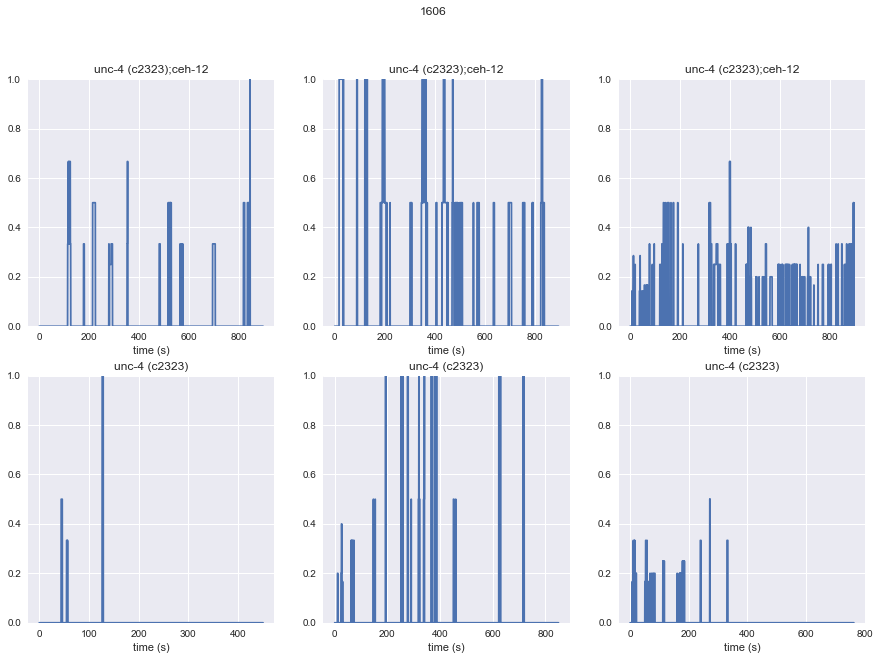

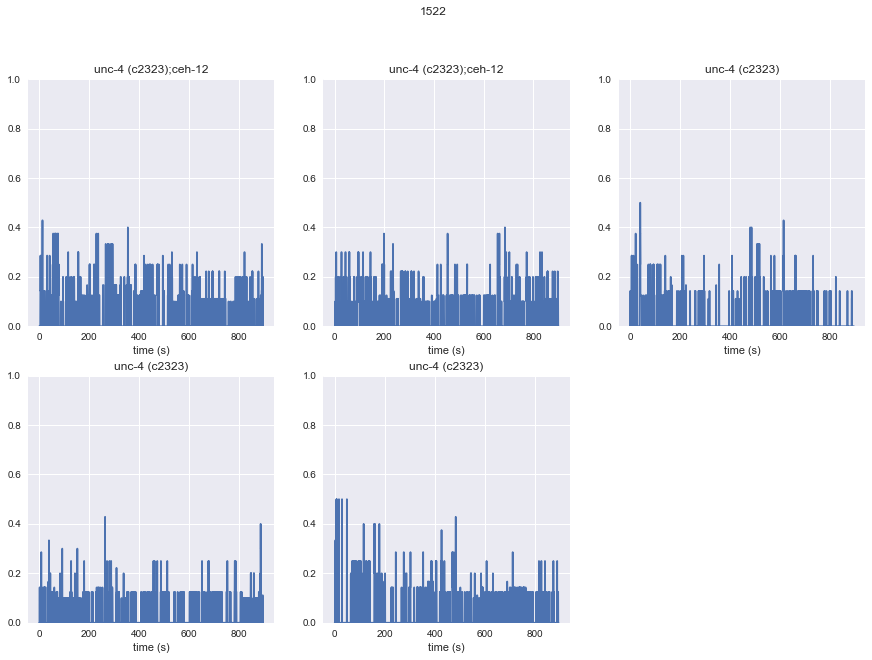

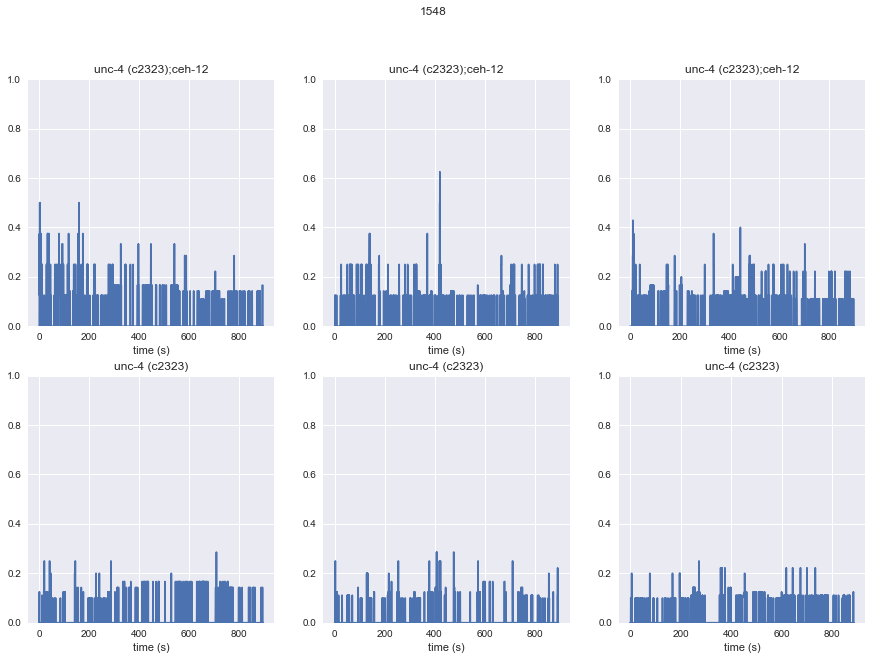

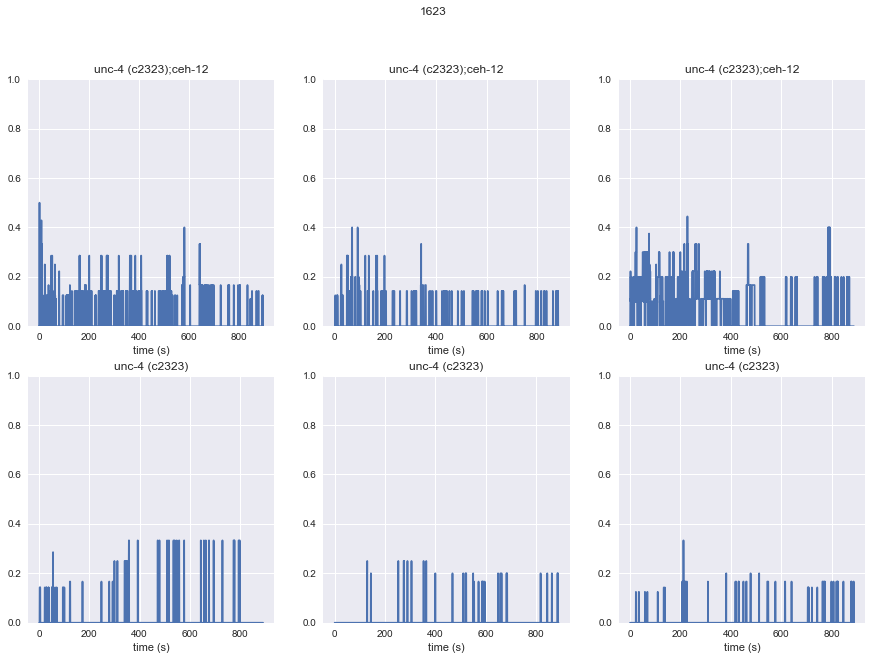

In [20]:
for time_rounded, feat_files in time_sets.items():
    plt.figure(figsize=(15,10))
    plt.suptitle(time_rounded)
    for ii, feat_file in enumerate(feat_files):
        with pd.HDFStore(feat_file, 'r') as fid:
            feat_timeseries = fid['/features_timeseries']

        rev_frac = add_reversal(feat_timeseries, th=-5)
        xx = np.arange(rev_frac.size)/25
        
        plt.subplot(2,3, ii +1)
        plt.plot(xx, rev_frac)
        base_name = os.path.basename(feat_file).replace('_features.hdf5', '')
        strain = base_name.split('_')[0]
        plt.title(strain)
        plt.xlabel('time (s)')
        plt.ylim((0,1))
    
